In [1]:
# # Path to h5ad dataset
# dataset_path = '/work/vanaja_lab/griffin/projects/cshmm/results/pancreas_dev.h5ad'

# # Load and prepare AnnData
# if os.path.exists(dataset_path):
#     print("File exists. Loading the dataset...")
#     adata = sc.read_h5ad(dataset_path)
#     print("Dataset loaded successfully!")
#     print("Dataset shape:", adata.shape)
# else:
#     raise FileNotFoundError(f"File not found at: {dataset_path}")

# adata.obs_names_make_unique()

# # Preprocessing steps
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # Min-max scaling
# scaler = MinMaxScaler()
# adata.X = scaler.fit_transform(adata.X.toarray())

# # HVG selection
# sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')
# adata = adata[:, adata.var['highly_variable']].copy()

# print(f"Dataset shape after selecting top 1000 HVGs: {adata.shape}")


In [2]:
# Dimensionality reduction and clustering
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=2, key_added="leiden")

# # Plot UMAP with clusters
# sc.pl.umap(adata, color="leiden", legend_loc="on data", title="UMAP - Leiden Clusters")

# # PAGA
# sc.tl.paga(adata, groups='leiden')
# sc.pl.paga(adata, color='leiden', title="PAGA Connectivity Graph")
# sc.pl.umap(adata, color=['leiden'], edges=True, title="UMAP with PAGA Connectivity")


In [3]:
#adata.write('data/mouse_panc_dev.h5ad')

In [4]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from models import TrajectoryGraph, initialize_trajectory


/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellr

In [5]:
adata = sc.read('data/mouse_panc_dev.h5ad')

In [6]:
# Build the trajectory graph
traj_graph, cell_assignment = initialize_trajectory(
    adata=adata,
    random_state=41,
    debug=True
)


Trajectory graph nodes: ['leaf_0', 'leaf_1', 'split_2', 'split_3', 'root_split_4', 'int_5', 'split_6', 'split_7', 'leaf_8', 'split_9', 'leaf_10', 'leaf_11', 'leaf_12', 'leaf_13', 'leaf_14', 'split_15', 'split_16', 'leaf_17', 'RootNode_0_0']
Trajectory graph edges: [('split_2', 'leaf_0'), ('split_2', 'leaf_12'), ('split_3', 'split_6'), ('split_3', 'split_9'), ('root_split_4', 'split_3'), ('root_split_4', 'split_16'), ('int_5', 'leaf_11'), ('split_6', 'leaf_1'), ('split_6', 'leaf_13'), ('split_7', 'leaf_8'), ('split_7', 'leaf_17'), ('split_9', 'leaf_10'), ('split_9', 'leaf_14'), ('split_15', 'split_2'), ('split_15', 'int_5'), ('split_16', 'split_7'), ('split_16', 'split_15'), ('RootNode_0_0', 'root_split_4')]

Sample cell assignments:
                                           edge  latent_time
TAAGCGTAGGCCCGTT  (RootNode_0_0, root_split_4)     0.773956
GACCAATAGTCGTCGT             (split_7, leaf_8)     0.438878
CGAGAAGCATGCTAGT  (RootNode_0_0, root_split_4)     0.858598
ACGATGTAGGATTCCC

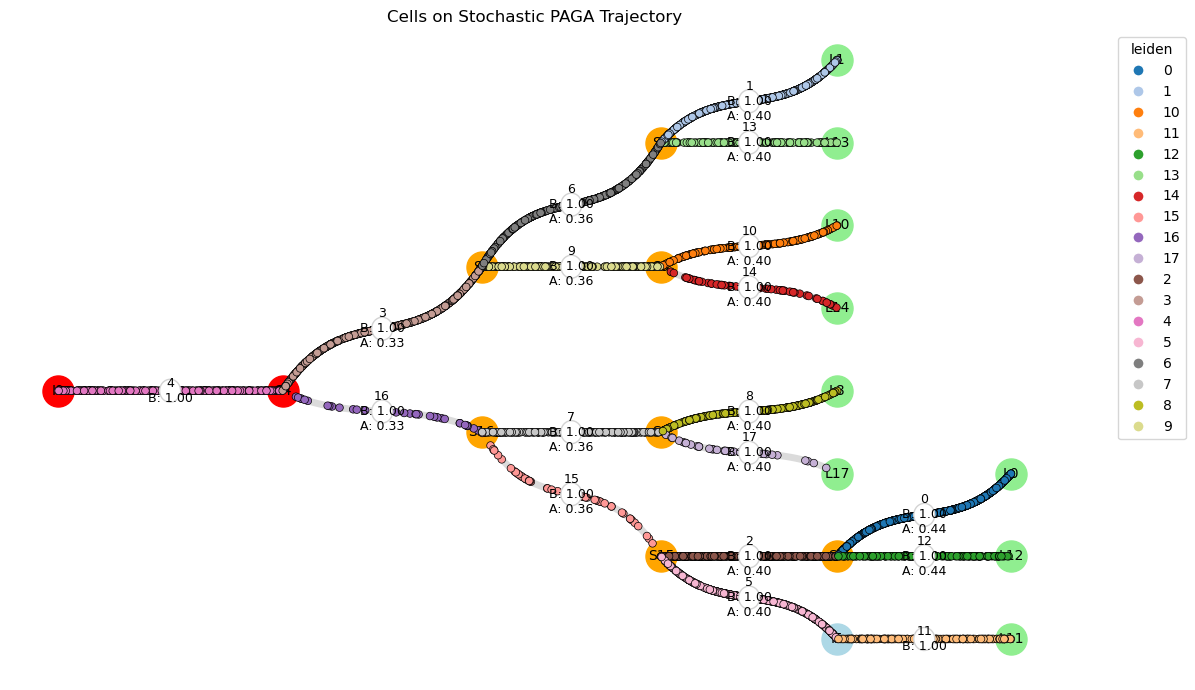

In [7]:
# Visualize trajectory graph with cells assigned
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='leiden',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Cells on Stochastic PAGA Trajectory",
    plot_transitions=True
)


In [8]:
# # === Imports ===

import torch
import numpy as np
from models.posterior import TreeVariationalPosterior
from models.belief import BeliefPropagator
from models.emission import pack_emission_params
from models.loss import compute_elbo
from utils.inference import initialize_beta_from_cell_assignment

# # === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Prepare expression data
X = torch.tensor(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    dtype=torch.float32
).to(device)

# Initialize emission parameters
edge_to_index, g_a, g_b, K, sigma2, pi = pack_emission_params(traj_graph, device=device)
g_a = g_a.requires_grad_()
g_b = g_b.requires_grad_()
K = K.requires_grad_()
log_sigma2 = torch.log(sigma2).requires_grad_()

# Posterior
n_cells = X.shape[0]
posterior = TreeVariationalPosterior(traj_graph, n_cells=n_cells, device=device)
posterior.path_logits = torch.nn.Parameter(torch.randn(n_cells, posterior.n_paths, device=device))

# Beta init
initialize_beta_from_cell_assignment(posterior, cell_assignment, sharpness=0.01)

# Belief propagation
belief_propagator = BeliefPropagator(traj_graph, posterior)

# Optimizer
params = [posterior.alpha, posterior.beta, posterior.path_logits, g_a, g_b, K, log_sigma2]
optimizer = torch.optim.Adam(params, lr=1e-2)

# Training config
num_epochs = 10
n_samples = 10
kl_weight = 1.0
kl_p_weight = 1.0
t_cont_weight = 1.0

# === Logging ===
def print_grad_stats():
    grad_alpha = posterior.alpha.grad.abs().mean().item()
    grad_beta = posterior.beta.grad.abs().mean().item()
    print(f"Gradients: α={grad_alpha:.3e}, β={grad_beta:.3e}")

def log_epoch(epoch, loss, metrics):
    print(f"[Epoch {epoch}] Loss: {loss.item():.3e}")
    print(f"  NLL:      {metrics['nll']:.3e}")
    print(f"  KL(t):    {metrics['kl_t']:.3f}")
    print(f"  KL(p):    {metrics['kl_p']:.3f}")
    print(f"  t_cont:   {metrics['t_cont']:.3f}")
    entropy = -(metrics['q_eff'] * metrics['q_eff'].clamp(min=1e-6).log()).sum(dim=1).mean()
    print(f"  Path entropy: {entropy:.3f}")

# Test Standard Full Code

In [10]:
# # === Run Variational Model ===
# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     loss, metrics = compute_elbo(
#         X, traj_graph, posterior, edge_to_index,
#         g_a, g_b, K, log_sigma2.exp(),
#         pi=pi,
#         belief_propagator=belief_propagator,
#         n_samples=n_samples,
#         kl_weight=kl_weight,
#         kl_p_weight=kl_p_weight,
#         t_cont_weight=t_cont_weight
#     )

#     loss.backward()
#     print_grad_stats()
#     log_epoch(epoch, loss, metrics)
#     optimizer.step()


In [11]:
from models.loss import compute_elbo_batch
from utils.inference import batch_indices

batch_size = 512
num_epochs = 5
n_samples = 3

optimizer = torch.optim.Adam(
    [posterior.alpha, posterior.beta, posterior.path_logits, g_a, g_b, K, log_sigma2],
    lr=1e-2
)

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0

    for batch in batch_indices(n_cells, batch_size):
        X_batch = X[batch]
        optimizer.zero_grad()
        
        loss, metrics = compute_elbo_batch(
            X_batch, batch,
            traj_graph, posterior, edge_to_index,
            g_a, g_b, K, log_sigma2.exp(),
            belief_propagator=belief_propagator,
            n_samples=n_samples,
            kl_weight=kl_weight,
            kl_p_weight=kl_p_weight,
            t_cont_weight=t_cont_weight,
            pi=pi
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    print(f"[Epoch {epoch}] Avg Loss: {total_loss / total_batches:.4e}")


[Epoch 0] Avg Loss: 8.2571e+05
[Epoch 1] Avg Loss: 5.3077e+05
[Epoch 2] Avg Loss: 3.3005e+05
[Epoch 3] Avg Loss: 2.1582e+05
[Epoch 4] Avg Loss: 1.4905e+05


In [12]:
freeze_epochs = 10
optimizer = torch.optim.Adam([
    {'params': [posterior.alpha, posterior.beta, posterior.path_logits]},
    {'params': [g_a, g_b, K, log_sigma2], 'lr': 1e-2}
], lr=1e-2)

for epoch in range(num_epochs):
    # Freeze emission parameters initially
    if epoch < freeze_epochs:
        for p in [g_a, g_b, K, log_sigma2]:
            p.requires_grad_(False)
    else:
        for p in [g_a, g_b, K, log_sigma2]:
            p.requires_grad_(True)

    optimizer.zero_grad()
    loss, metrics = compute_elbo(
        X, traj_graph, posterior, edge_to_index,
        g_a, g_b, K, log_sigma2.exp(),
        pi=pi,
        belief_propagator=belief_propagator,
        n_samples=n_samples,
        kl_weight=kl_weight,
        kl_p_weight=kl_p_weight,
        t_cont_weight=t_cont_weight,
    )
    loss.backward()
    optimizer.step()

    print(f"[Epoch {epoch}] Loss={loss.item():.2e}, NLL={metrics['nll']:.2e}, KL(t)={metrics['kl_t']:.3f}")


[Epoch 0] Loss=1.28e+05, NLL=1.28e+05, KL(t)=0.214
[Epoch 1] Loss=1.27e+05, NLL=1.27e+05, KL(t)=0.215
[Epoch 2] Loss=1.27e+05, NLL=1.27e+05, KL(t)=0.217
[Epoch 3] Loss=1.26e+05, NLL=1.26e+05, KL(t)=0.218
[Epoch 4] Loss=1.26e+05, NLL=1.26e+05, KL(t)=0.220


In [13]:
inference_params = [posterior.alpha, posterior.beta, posterior.path_logits]
generative_params = [g_a, g_b, K, log_sigma2]

optimizer_inf = torch.optim.Adam(inference_params, lr=1e-2)
optimizer_gen = torch.optim.Adam(generative_params, lr=1e-2)

n_inf_steps = 5
n_gen_steps = 1
batch_size = 512

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch}]")

    # === Inference Phase ===
    for _ in range(n_inf_steps):
        optimizer_inf.zero_grad()
        total_elbo = 0
        for batch in batch_indices(X.shape[0], batch_size):
            X_batch = X[batch]
            elbo, _ = compute_elbo_batch(
                X_batch, batch,
                traj_graph, posterior, edge_to_index,
                g_a, g_b, K, log_sigma2.exp(),
                belief_propagator=belief_propagator,
                n_samples=n_samples,
                kl_weight=kl_weight,
                kl_p_weight=kl_p_weight,
                t_cont_weight=t_cont_weight,
                pi=pi
            )
            elbo.backward()
            total_elbo += elbo.item()
        optimizer_inf.step()
        print(f"Inference ELBO: {total_elbo:.2e}")

    # === Generative Phase ===
    for _ in range(n_gen_steps):
        optimizer_gen.zero_grad()
        total_elbo = 0
        for batch in batch_indices(X.shape[0], batch_size):
            X_batch = X[batch]
            elbo, _ = compute_elbo_batch(
                X_batch, batch,
                traj_graph, posterior, edge_to_index,
                g_a, g_b, K, log_sigma2.exp(),
                belief_propagator=belief_propagator,
                n_samples=n_samples,
                kl_weight=kl_weight,
                kl_p_weight=kl_p_weight,
                t_cont_weight=t_cont_weight,
                pi=pi
            )
            elbo.backward()
            total_elbo += elbo.item()
        optimizer_gen.step()
        print(f"Generative ELBO: {total_elbo:.2e}")



[Epoch 0]
Inference ELBO: 1.38e+06
Inference ELBO: 1.39e+06
Inference ELBO: 1.38e+06
Inference ELBO: 1.37e+06
Inference ELBO: 1.38e+06
Generative ELBO: 1.35e+06

[Epoch 1]
Inference ELBO: 1.39e+06
Inference ELBO: 1.40e+06
Inference ELBO: 1.39e+06
Inference ELBO: 1.36e+06
Inference ELBO: 1.38e+06
Generative ELBO: 1.40e+06

[Epoch 2]
Inference ELBO: 1.39e+06
Inference ELBO: 1.40e+06
Inference ELBO: 1.34e+06
Inference ELBO: 1.38e+06
Inference ELBO: 1.37e+06
Generative ELBO: 1.36e+06

[Epoch 3]
Inference ELBO: 1.36e+06
Inference ELBO: 1.38e+06
Inference ELBO: 1.42e+06
Inference ELBO: 1.33e+06
Inference ELBO: 1.38e+06
Generative ELBO: 1.39e+06

[Epoch 4]
Inference ELBO: 1.33e+06
Inference ELBO: 1.39e+06
Inference ELBO: 1.36e+06
Inference ELBO: 1.36e+06
Inference ELBO: 1.39e+06
Generative ELBO: 1.37e+06
